<a href="https://colab.research.google.com/github/HuitingSong/ANLY-580/blob/main/lab_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab-09: DBpedia14 classification with BERT

In Lab-03 we used linear text classification models (the perceptron, linear SVM, multinomial naive Bayes, softmax regression) on the DBpedia14 dataset. Recall that our best test accuracy was in the 92-93% range, and in lecture 08 we used a feed-forward NN with CBOW features to achieve ~97% test accuracy. Here we will use the BERT transformer model that was pretrained on vast amounts of text data to achieve >99% test accuracy with minimal hyperparameter tuning.

### Class labels

In [7]:
labels = {
    0: "Company",
    1: "EducationalInstitution",
    2: "Artist",
    3: "Athlete",
    4: "OfficeHolder",
    5: "MeanOfTransportation",
    6: "Building",
    7: "NaturalPlace",
    8: "Village",
    9: "Animal",
    10: "Plant",
    11: "Album",
    12: "Film",
    13: "WrittenWork"
}

K = len(labels)

## Download the dataset

In [8]:
# Colab provides limited GPU time (be mindful when increasing this number)
M = 30000

In [9]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import datasets
import pandas as pd

df_train, df_test = datasets.load_dataset(
    'dbpedia_14', 
    split=['train', 
           'test']
)

df_train = df_train.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.8 * M)]
df_test = df_test.to_pandas().sample(frac=1).reset_index(drop=True)[:int(0.2 * M)]

  0%|          | 0/2 [00:00<?, ?it/s]

### (3 pts) Task 1: Analyze the data

a. What is the distribution of the labels in this data? 

*Hint*: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html

b. Compute the distribution of sentence length in the dataset

c. Are there any differences between the train and test sets? If so make any necessary changes to the train/test sets such that they look the same.

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

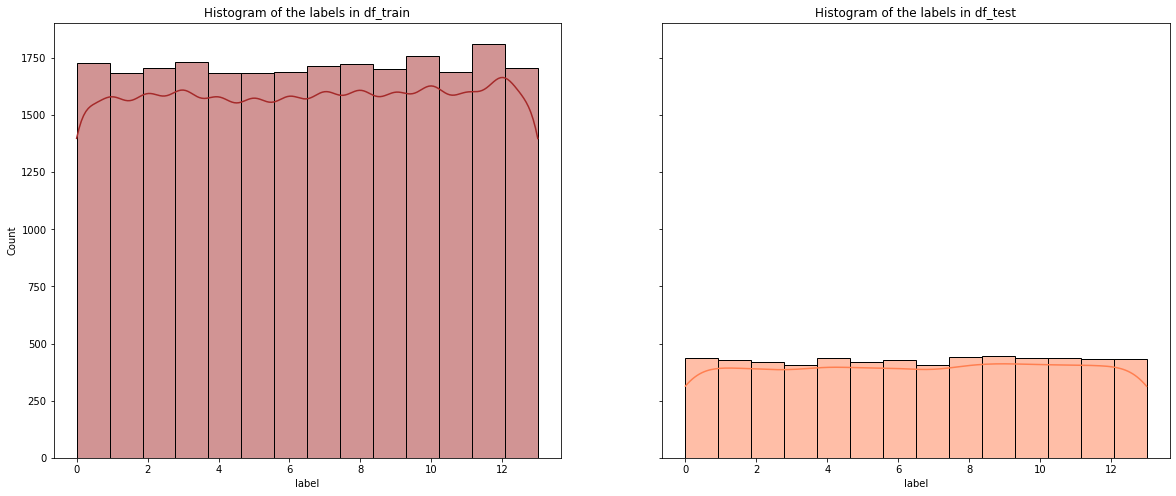

In [6]:
# Your code goes here

# a. 
# The distributions of the labels in both train and test datasets are like uniform distribution.

fig,ax= plt.subplots(1,2,figsize=(20, 8),sharey=True) # plot side by side
sns.histplot(df_train['label'], kde=True, bins=14,ax=ax[0],color= 'brown') # for labeles in df_train
sns.histplot(df_test['label'], kde=True, bins=14,ax=ax[1],color='coral') # for labels in df_test
ax[0].set_title('Histogram of the labels in df_train')
ax[1].set_title('Histogram of the labels in df_test')
fig.show()

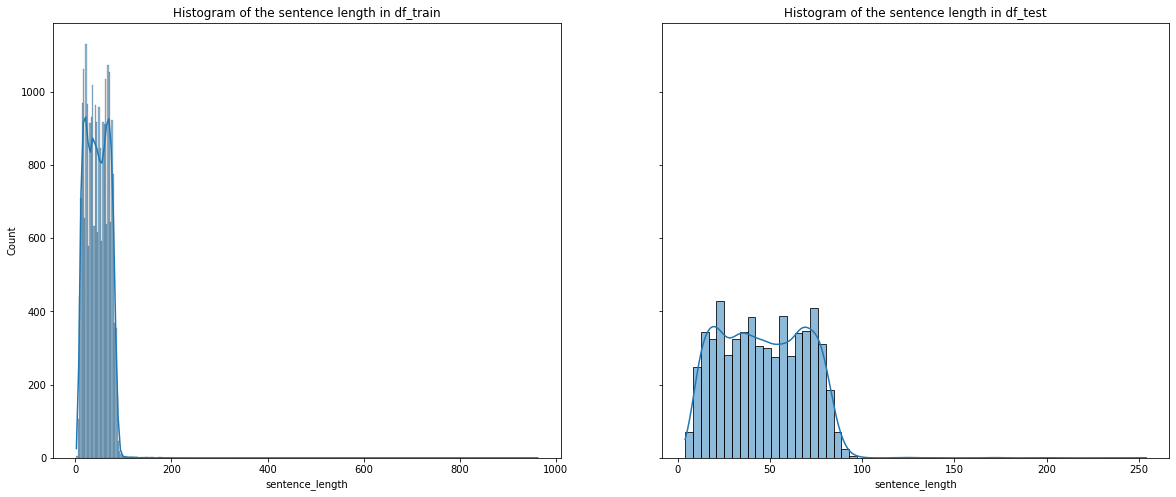

In [8]:
# b. 
# The distribution of sentence length in this dataset is like unifrom

df_train['sentence_length'] = df_train.content.str.split().str.len()
df_test['sentence_length'] = df_test.content.str.split().str.len()

fig,ax= plt.subplots(1,2,figsize=(20, 8),sharey=True) # plot side by side
sns.histplot(df_train['sentence_length'],kde=True,ax=ax[0]) # for sentence length in df_train
sns.histplot(df_test['sentence_length'],kde=True,ax=ax[1]) # for sentence length in df_test
ax[0].set_title('Histogram of the sentence length in df_train')
ax[1].set_title('Histogram of the sentence length in df_test')
fig.show()

In [20]:
# c. 
# there are no difference in distribution between df_train and df_test. 
# They both are in different size but are still like unifrom distribution. 

## Train BERT on DBpedia14

Here you will use Google CoLab, which provides free (but limited) use of hosted GPU instances.

Before doing this, take a look at the leaderboard for DBpedia14: https://paperswithcode.com/dataset/dbpedia. You'll find various transformers (including BERT) at the top. Here we will use a smaller version of BERT called DistilBERT which reduces the computational overhead with only marginal performance degradation, and only two training epochs over an abridged version of the dataset.

### Google CoLab

To complete the tasks below you will need to login to a Google account and then go here: https://colab.research.google.com. Then do the following:

1. End any existing CoLab sessions that you have running

2. Click on the `Upload` tab and upload this file

3. Click on `Runtime -> Change runtime type` and select `GPU`

### Install packages

In [11]:
!pip install -q transformers torch

### Restart runtime

After running the cell above, click `Runtime -> Restart runtime`. This only needs to be done one time per session.

### Training Hyperparameters

In [12]:
batch_size = 32
epochs = 2
lr_init = 1e-5
max_len = 128
warmup_steps = 3

### (7 pts) Task 2: Create batched inputs using Huggingface's DistilBERT tokenizer 

In [13]:
from typing import List, Tuple
import torch
from transformers import DistilBertTokenizerFast
from transformers.tokenization_utils_base import BatchEncoding

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

In [14]:
import pandas as pd

In [37]:
def batch_data(data: pd.DataFrame, bsize: int) -> List[Tuple[BatchEncoding, List[int], List[str]]]:
    """
    This Function accepts a Pandas DataFrame and a batch size and returns
    a list of training 'batches', each of which is a tuple of:
        ( X, Y, s )
    where
        X: BatchEncoding ∈ R^(`bsize` x `T_max` x `D`)    inputs
        Y: torch.Tensor ∈ Z^(`bsize` x `1`)               ground truth labels
        s: List[str] w/ len `bsize`                       sentences (i.e., documents)
    
    Note: refer to the `DistilBertTokenizerFast.batch_encode_plus()` method to produce X
    """
    # Your code goes here
    batches = [] # list of batches
    for i in range(0, len(list(data['content'])), bsize):
      Y = list(data['label'])[i: i + bsize]
      s = list(data['content'])[i: i + bsize]
      X = tokenizer.batch_encode_plus(s)
      batches.append((X, Y, s))
    return batches

### Create train/test splits

In [38]:
train_batches = batch_data(df_train, bsize=batch_size)
test_batches = batch_data(df_test, bsize=batch_size)

### Load pretrained Distilbert model

This cell uses the `DistilBertForSequenceClassification` class, which is a convenience wrapper that places a classification head onto the DistilBert language model. 

In [39]:
from tqdm import tqdm
import torch
from transformers import DistilBertForSequenceClassification, \
  AdamW, get_linear_schedule_with_warmup

# Transformer model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-cased', 
    num_labels=K, 
    output_hidden_states=True)

# The torch `device` on which to execute the model computation
if torch.cuda.is_available():
    device = torch.device('cuda:0') # GPU
else:
    device = torch.device('cpu') # CPU
model.to(device)

# The gradient descent optimizer used for fine tuning
optimizer = AdamW(model.parameters(), lr=lr_init)

# The gradient descent learning rate
lr = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, 
    num_training_steps=len(train_batches))

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.w

### (10 pts) Task 3: Implement a training loop from scratch

Here you need to:

1. Implement the `runner()` method below
2. Train the DistilBert model on the training set
3. Compute and print out the loss, accuracy, and f1-score of the trained model on the train and tests sets
4. Provide a brief summary of the results and place them in context to other modeling approaches (e.g.word2vec from lecture 03, the CBOW NN from lecture 08).

*Note: You're encouraged to use the Huggingface documentation to complete this task!*

*Note: This should take about 20 minutes on CoLabs K80 GPUs*

In [43]:
from datasets import load_metric

def runner(batches, desc: str, train=True):
    """
    This function accepts a list of batches (i.e., the output of batch_data())
    and returns a tuple consisting of:
        (predictions, cls-embeddings, mean-loss, accuracy, f1-score)
    where
        preditions: List[pred for each input]
        cls-embeddings: List[bert's cls embeddings for each input]
        mean-loss: mean loss computed over data in batches
        mean-accuracy: mean accuracy computed over data in batches
        mean-f1-score: mean f1 score computed over data in batches
    """
    pred =[]
    acc = load_metric("accuracy")
    f1 = load_metric("f1")
    cumloss = 0.0

    for i, batch in enumerate(batches):
      X, Y, s = batch
      input_ids = torch.tensor(X['input_ids'])
      attention_mask = torch.tensor(X['attention_mask'])
      labels = torch.tensor(Y)
      batch = {'input_ids': input_ids,
               'attention_mask': attention_mask,
               'labels': labels}

    outputs = model(**batch, labels=labels)
    loss = outputs.loss
    logits = outputs.logits

    predicted = torch.argmax(logits, dim=-1)
    pred.append(predicted)
    cumloss += loss.clone().detach().cpu().item()
    acc.add_batch(predictions=predicted, references=Y)
    f1.add_batch(predictions=predicted, references=Y)

    return preds

### (2 pts) Task 4: test your model on new string

Make up (or find) a document that maps to one of the 14 classes in DBpedia14. Is the model's prediction in agreement with your label assignment? The cell below contains some helper code to get you started. To compute the model prediction, reuse the `batch_data()` and `runner()` functions.

In [40]:
import numpy as np
import pandas as pd

example_text = """Her is a 2013 American science-fiction romantic drama film written, 
directed, and produced by Spike Jonze. It marks Jonze's solo screenwriting debut. 
The film follows Theodore Twombly (Joaquin Phoenix), a man who develops a relationship 
with Samantha (Scarlett Johansson), an artificially intelligent virtual assistant 
personified through a female voice."""

example_ground_truth_label = 12 # "film"

df = pd.DataFrame({'content': [example_text], 
                   'label': example_ground_truth_label, 
                   'title': None})

In [44]:
# Your code goes here
batches_new = batch_data(df, bsize=batch_size)
runner(batches_new, 'test_example', train=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  app.launch_new_instance()


TypeError: ignored

### (3 pts) Task 5: Extract the document embeddings and visualize them in Tensorboard Projector

### TSV helper functions from Lecture 05

In [45]:
def save_matrix(matrix, fpath):
    D1, D2 = matrix.shape
    tsv = ""
    for i in range(D1):
        for j in range(D2):
            tsv += str(matrix[i, j]) + '\t'
        tsv = tsv.strip('\t') + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

def save_docs(docs, labels, fpath):
    tsv = "document\tlabel\n"
    for doc, label in zip(docs, labels):
        tsv += doc.lower().strip() + '\t' + label + '\n'
    tsv = tsv.strip('\n')
    with open(fpath, "w") as fd:
        fd.write(tsv)

### Extract embeddings

In [ ]:
# Your code goes here


### Visualize embeddings

The embeddings and text can be saved in tsv format and uploaded here  https://projector.tensorflow.org/ for visualization. Choose the tSNE algorithm.

In [ ]:
# Your code goes here